In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from collections import Counter

% matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

In [2]:
regions = dict(
    
    lfp = [
        "ctx_lh_S_front_sup.nii.gz",
        "ctx_lh_G_precentral.nii.gz",
        "ctx_lh_G_front_middle.nii.gz",
        "ctx_lh_G_and_S_cingul-Ant.nii.gz"
    ],
    
    rfp = [
        "ctx_rh_G_front_sup.nii.gz",
        "ctx_rh_G_postcentral.nii.gz",
        "ctx_rh_G_front_middle.nii.gz",
        "ctx_rh_G_front_inf-Orbital.nii.gz",
        "ctx_rh_G_and_S_transv_frontopol.nii.gz",
        "ctx_rh_G_precentral.nii.gz",
        "ctx_rh_S_front_middle.nii.gz",
        "ctx_rh_G_and_S_cingul-Ant.nii.gz"
    ],
    
    lt = [
        "ctx_lh_S_temporal_inf.nii.gz",
        "ctx_lh_G_temp_sup-G_T_transv.nii.gz",
        "ctx_lh_G_temporal_middle.nii.gz",
        "ctx_lh_G_temp_sup-Plan_polar.nii.gz",
        "ctx_lh_G_temp_sup-Lateral.nii.gz",
        "ctx_lh_G_temporal_inf.nii.gz",
        "ctx_lh_G_temp_sup-Plan_tempo.nii.gz",
        "ctx_lh_S_temporal_sup.nii.gz"
    ],
    
    rt = [
        "ctx_rh_G_temp_sup-Lateral.nii.gz",
        "ctx_rh_S_temporal_transverse.nii.gz",
        "ctx_rh_G_temp_sup-Plan_polar.nii.gz",
        "ctx_rh_G_temporal_middle.nii.gz",
        "ctx_rh_S_temporal_sup.nii.gz",
        "ctx_rh_G_temp_sup-Plan_tempo.nii.gz",
        "ctx_rh_G_temporal_inf.nii.gz",
        "ctx_rh_S_temporal_inf.nii.gz",
        "ctx_rh_G_temp_sup-G_T_transv.nii.gz"
    ],
    
    sc = [
        "Right-Thalamus-Proper.nii.gz",
        "Left-Thalamus-Proper.nii.gz",
        "Right-Accumbens-area.nii.gz",
        "Left-Accumbens-area.nii.gz",
        "Right-Caudate.nii.gz",
        "Left-Caudate.nii.gz",
        "Right-Putamen.nii.gz",
        "Left-Putamen.nii.gz",
        "Right-Amygdala.nii.gz",
        "Left-Amygdala.nii.gz",
        "Right-Hippocampus.nii.gz",
        "Left-Hippocampus.nii.gz"
    ]
    
)

In [3]:
means = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0)
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == means.index)) #should be 1.0

1.0


In [4]:
ls

3dbrainviz.ipynb                      linear_models.ipynb
RFCUSTOM.py                           multi_classif.ipynb
all_td_age.csv                        oldk_vs_adult/
alldata_rf_model.png                  oos_roc_rf.txt
behav.txt                             regional.ipynb
feature_per_iteration_inclusions.csv  resh5py
fszstatcope2_means_all.csv            results_with_nullmodel.h5py
fszstatcope2_means_nz.csv             rf_featselect.ipynb
fszstatcope2_means_nz_valset.csv      rf_regression.ipynb
fszstatcope2_nvoxels_all.csv          rochist.png
fszstatcope2_nvoxels_nz.csv           test_h5py
fszstatcope2_nvoxels_nz_valset.csv    valset_behav.csv
git/                                  yk_ad_results_with_nullmodel.h5py
glm.ipynb                             yk_ok_results_with_nullmodel.h5py
kids_vs_adults_alldata_rf_model.png   youngk_vs_adult/
kids_vs_adults_rochists_featElim.png  youngk_vs_oldk/


In [5]:
behav2g = behav[np.logical_or(behav.young_kid == 1, behav.adult == 1)]
data2g = means[np.logical_or(behav.young_kid == 1, behav.adult == 1)]

In [6]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

In [7]:
def random_forest_model(data, y, cv, clf):
    X, P = data.values, data.shape[1]
    results = dict(pred=[], ytrue=[], fi=[], fidx=[])
    results_null = dict(pred=[], ytrue=[], fi=[], fidx=[])
    
    for idx, (train, test) in enumerate(cv.split(X, y)):   
        clf.fit(X[train], y[train])
        results["pred"].append(clf.predict(X[test]))
        results["ytrue"].append(y[test])
        results["fi"].append(clf.feature_importances_)
        results["fidx"].append([True for i in range(P)])
        
        # this is to compute the null model
        try:
            y_shuff = np.copy(y[train])
            np.random.shuffle(y_shuff)
            clf.fit(X[train], y_shuff)
            results_null["pred"].append(clf.predict(X[test]))
            results_null["ytrue"].append(y[test])
            results_null["fi"].append(clf.feature_importances_)
            results_null["fidx"].append([True for i in range(P)])
        except:
            print("couldn't compute null model")
        
    
    roc = roc_auc_score(np.array(results["ytrue"]).ravel(), np.array(results["pred"]).ravel())
    
    # this is to compute the null model
    try:
        roc_null = roc_auc_score(
            np.array(results_null["ytrue"]).ravel(),
            np.array(results_null["pred"]).ravel()
        )
    except:
        print("couldn't compute null roc score")
        
    return results, roc, results_null, roc_null

In [8]:
data2g = projection(data2g, behav2g.loc[:, ["gender", "iq", "composite_motion"]])

In [12]:
data_sets = {}

for key, group in regions.items():
    data_sets[key] = data2g.loc[:, group]
    

In [14]:
print(1)

1


In [13]:
niters=100
rocs = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
rocs_null = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
res = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
res_null = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
 
for key, val in data_sets.items():
    for i_iter in np.arange(niters):
        cv=LeaveOneOut()
        clf=RandomForestClassifier(n_estimators=1000, n_jobs=4)
        
        res_g, roc_g, resnull_g, rocnull_g = random_forest_model(
            val, 
            behav2g.young_kid.values,
            cv,
            clf
        )
        
        rocs[key].append(roc_g)
        rocs_null[key].append(rocnull_g)
        res[key].append(res_g)
        res_null[key].append(resnull_g)

# predictive roc scores

In [15]:
for key, val in rocs.items():
    print(key, "\t", np.mean(val))

lfp 	 0.7156818181818183
rfp 	 0.5916363636363636
lt 	 0.5707636363636364
rt 	 0.5460272727272726
sc 	 0.3316454545454545


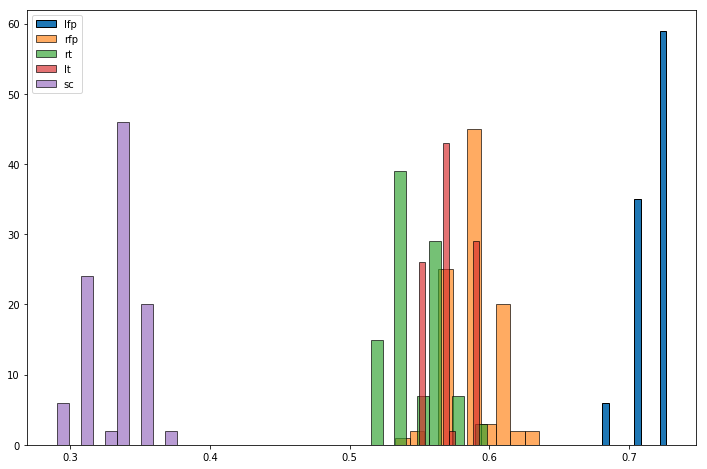

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(rocs["lfp"], edgecolor="black")
plt.hist(rocs["rfp"], edgecolor="black", alpha=.65)
plt.hist(rocs["rt"], edgecolor="black", alpha=.65)
plt.hist(rocs["lt"], edgecolor="black", alpha=.65)
plt.hist(rocs["sc"], edgecolor="black", alpha=.65)
plt.legend(["lfp", "rfp", "rt", "lt", "sc"])

# empirical p-values

In [17]:
for key in ["lfp", "rfp", "lt", "rt", "sc"]:
    pval = (np.sum(rocs_null[key] >= np.mean(rocs[key])) + 1) / (niters + 1)
    print("region: {} p-value: {}".format(key, pval))

region: lfp p-value: 0.009900990099009901
region: rfp p-value: 0.0297029702970297
region: lt p-value: 0.09900990099009901
region: rt p-value: 0.1485148514851485
region: sc p-value: 0.9801980198019802


# feature importances

In [18]:
lfp_imps = np.zeros((niters, len(regions["lfp"])))
rfp_imps = np.zeros((niters, len(regions["rfp"])))
lt_imps = np.zeros((niters, len(regions["lt"])))
rt_imps = np.zeros((niters, len(regions["rt"])))
sc_imps = np.zeros((niters, len(regions["sc"])))

for i in np.arange(niters):
    lfp_imps[i, :] = np.array(res["lfp"][i]["fi"]).mean(0)
    rfp_imps[i, :] = np.array(res["rfp"][i]["fi"]).mean(0)
    lt_imps[i, :] = np.array(res["lt"][i]["fi"]).mean(0)
    rt_imps[i, :] = np.array(res["rt"][i]["fi"]).mean(0)
    sc_imps[i, :] = np.array(res["sc"][i]["fi"]).mean(0)

In [19]:
for pair in zip(regions["lfp"], lfp_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_lh_S_front_sup.nii.gz 	 0.23381592656424502
ctx_lh_G_precentral.nii.gz 	 0.275069220646934
ctx_lh_G_front_middle.nii.gz 	 0.1896295608221924
ctx_lh_G_and_S_cingul-Ant.nii.gz 	 0.30148529196662843


In [20]:
for pair in zip(regions["rfp"], rfp_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_rh_G_front_sup.nii.gz 	 0.10068001569574785
ctx_rh_G_postcentral.nii.gz 	 0.19956284765592203
ctx_rh_G_front_middle.nii.gz 	 0.12155000433481296
ctx_rh_G_front_inf-Orbital.nii.gz 	 0.11314959854641472
ctx_rh_G_and_S_transv_frontopol.nii.gz 	 0.09232511063868765
ctx_rh_G_precentral.nii.gz 	 0.16717320845487763
ctx_rh_S_front_middle.nii.gz 	 0.09685848221054597
ctx_rh_G_and_S_cingul-Ant.nii.gz 	 0.10870073246299108


In [21]:
for pair in zip(regions["lt"], lt_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_lh_S_temporal_inf.nii.gz 	 0.12582463109644748
ctx_lh_G_temp_sup-G_T_transv.nii.gz 	 0.11541909668498272
ctx_lh_G_temporal_middle.nii.gz 	 0.13321838855091506
ctx_lh_G_temp_sup-Plan_polar.nii.gz 	 0.10047604627088765
ctx_lh_G_temp_sup-Lateral.nii.gz 	 0.11273401084991069
ctx_lh_G_temporal_inf.nii.gz 	 0.12673038265104997
ctx_lh_G_temp_sup-Plan_tempo.nii.gz 	 0.1157178688927132
ctx_lh_S_temporal_sup.nii.gz 	 0.1698795750030932


In [22]:
for pair in zip(regions["rt"], rt_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_rh_G_temp_sup-Lateral.nii.gz 	 0.10026391106219722
ctx_rh_S_temporal_transverse.nii.gz 	 0.094971337041867
ctx_rh_G_temp_sup-Plan_polar.nii.gz 	 0.08275003645705142
ctx_rh_G_temporal_middle.nii.gz 	 0.14580320929187937
ctx_rh_S_temporal_sup.nii.gz 	 0.11461589701558156
ctx_rh_G_temp_sup-Plan_tempo.nii.gz 	 0.10099170635389973
ctx_rh_G_temporal_inf.nii.gz 	 0.12235975049822613
ctx_rh_S_temporal_inf.nii.gz 	 0.14163489142232547
ctx_rh_G_temp_sup-G_T_transv.nii.gz 	 0.09660926085697188


In [23]:
for pair in zip(regions["sc"], sc_imps.mean(0)):
    print(pair[0], "\t", pair[1])

Right-Thalamus-Proper.nii.gz 	 0.07866218241230546
Left-Thalamus-Proper.nii.gz 	 0.08824306775343688
Right-Accumbens-area.nii.gz 	 0.08086414653224808
Left-Accumbens-area.nii.gz 	 0.07218731952475699
Right-Caudate.nii.gz 	 0.06664789574260055
Left-Caudate.nii.gz 	 0.08042711603119067
Right-Putamen.nii.gz 	 0.09756005089933222
Left-Putamen.nii.gz 	 0.10226584105442559
Right-Amygdala.nii.gz 	 0.08937681298036847
Left-Amygdala.nii.gz 	 0.0806139051095017
Right-Hippocampus.nii.gz 	 0.08037895778293573
Left-Hippocampus.nii.gz 	 0.0827727041768977


# now doing young kids vs older kids

In [9]:
behav_ykok = behav[np.logical_or(behav.old_kid == 1, behav.adult == 1)]
data_ykok = means[np.logical_or(behav.old_kid == 1, behav.adult == 1)]
data_ykok = projection(data_ykok, behav_ykok.loc[:, ["gender", "iq", "composite_motion"]])

In [22]:
data_sets_ykok = {}

for key, group in regions.items():
    data_sets_ykok[key] = data_ykok.loc[:, group]

In [23]:
niters=2
rocs_ykok = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
rocs_null_ykok = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
res_ykok = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
res_null_ykok = {"lfp":[], "rfp":[], "lt":[], "rt":[], "sc":[]}
 
for key, val in data_sets_ykok.items():
    for i_iter in np.arange(niters):
        cv=LeaveOneOut()
        clf=RandomForestClassifier(n_estimators=1000)
        
        res_g, roc_g, resnull_g, rocnull_g = random_forest_model(
            val, 
            behav_ykok.old_kid.values,
            cv,
            clf
        )
        
        rocs_ykok[key].append(roc_g)
        rocs_null_ykok[key].append(rocnull_g)
        res_ykok[key].append(res_g)
        res_null_ykok[key].append(resnull_g)

# predictive roc scores

In [25]:
for key, val in rocs_ykok.items():
    print(key, "\t", np.mean(val))

lfp 	 0.5489811912225705
rfp 	 0.5125391849529781
lt 	 0.45219435736677116
rt 	 0.5803291536050157
sc 	 0.5239028213166144


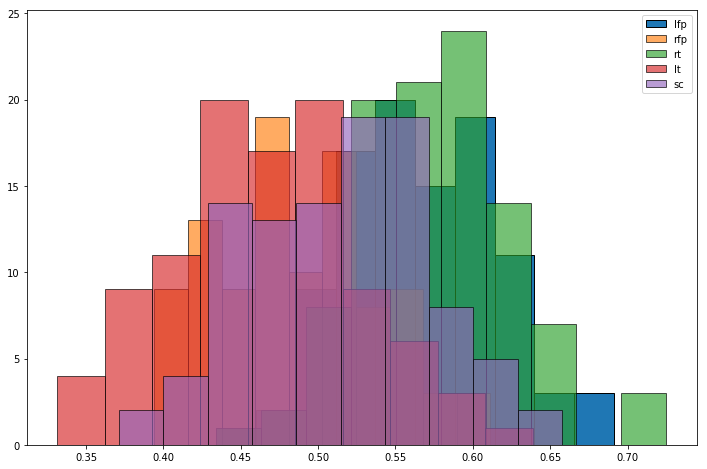

In [13]:
plt.figure(figsize=(12, 8))
plt.hist(rocs_ykok["lfp"], edgecolor="black")
plt.hist(rocs_ykok["rfp"], edgecolor="black", alpha=.65)
plt.hist(rocs_ykok["rt"], edgecolor="black", alpha=.65)
plt.hist(rocs_ykok["lt"], edgecolor="black", alpha=.65)
plt.hist(rocs_ykok["sc"], edgecolor="black", alpha=.65)
plt.legend(["lfp", "rfp", "rt", "lt", "sc"])

# empirical p-values

In [14]:
for key in ["lfp", "rfp", "lt", "rt", "sc"]:
    pval = (np.sum(rocs_null_ykok[key] >= np.mean(rocs_ykok[key])) + 1) / (niters + 1)
    print("region: {} p-value: {}".format(key, pval))

region: lfp p-value: 0.1188118811881188
region: rfp p-value: 0.39603960396039606
region: lt p-value: 0.5346534653465347
region: rt p-value: 0.0891089108910891
region: sc p-value: 0.32673267326732675


# feature importances

In [15]:
lfp_imps = np.zeros((niters, len(regions["lfp"])))
rfp_imps = np.zeros((niters, len(regions["rfp"])))
lt_imps = np.zeros((niters, len(regions["lt"])))
rt_imps = np.zeros((niters, len(regions["rt"])))
sc_imps = np.zeros((niters, len(regions["sc"])))

for i in np.arange(niters):
    lfp_imps[i, :] = np.array(res_ykok["lfp"][i]["fi"]).mean(0)
    rfp_imps[i, :] = np.array(res_ykok["rfp"][i]["fi"]).mean(0)
    lt_imps[i, :] = np.array(res_ykok["lt"][i]["fi"]).mean(0)
    rt_imps[i, :] = np.array(res_ykok["rt"][i]["fi"]).mean(0)
    sc_imps[i, :] = np.array(res_ykok["sc"][i]["fi"]).mean(0)

In [16]:
for pair in zip(regions["lfp"], lfp_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_lh_S_front_sup.nii.gz 	 0.22623770467932355
ctx_lh_G_precentral.nii.gz 	 0.2154855820108035
ctx_lh_G_front_middle.nii.gz 	 0.22561946611338574
ctx_lh_G_and_S_cingul-Ant.nii.gz 	 0.3326572471964871


In [17]:
for pair in zip(regions["rfp"], rfp_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_rh_G_front_sup.nii.gz 	 0.11655848242298424
ctx_rh_G_postcentral.nii.gz 	 0.14757171053581142
ctx_rh_G_front_middle.nii.gz 	 0.11200267524620106
ctx_rh_G_front_inf-Orbital.nii.gz 	 0.10938193487309794
ctx_rh_G_and_S_transv_frontopol.nii.gz 	 0.11890898104113262
ctx_rh_G_precentral.nii.gz 	 0.11777821877226655
ctx_rh_S_front_middle.nii.gz 	 0.13039192486906415
ctx_rh_G_and_S_cingul-Ant.nii.gz 	 0.14740607223944205


In [18]:
for pair in zip(regions["lt"], lt_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_lh_S_temporal_inf.nii.gz 	 0.1427769380109275
ctx_lh_G_temp_sup-G_T_transv.nii.gz 	 0.11572658973380417
ctx_lh_G_temporal_middle.nii.gz 	 0.1147756714673136
ctx_lh_G_temp_sup-Plan_polar.nii.gz 	 0.12819658292271113
ctx_lh_G_temp_sup-Lateral.nii.gz 	 0.11313424393443164
ctx_lh_G_temporal_inf.nii.gz 	 0.1489376213438779
ctx_lh_G_temp_sup-Plan_tempo.nii.gz 	 0.1151607212797493
ctx_lh_S_temporal_sup.nii.gz 	 0.12129163130718477


In [19]:
for pair in zip(regions["rt"], rt_imps.mean(0)):
    print(pair[0], "\t", pair[1])

ctx_rh_G_temp_sup-Lateral.nii.gz 	 0.1357690914619825
ctx_rh_S_temporal_transverse.nii.gz 	 0.08613979104481354
ctx_rh_G_temp_sup-Plan_polar.nii.gz 	 0.09739255270516389
ctx_rh_G_temporal_middle.nii.gz 	 0.136885788446309
ctx_rh_S_temporal_sup.nii.gz 	 0.14824241984758366
ctx_rh_G_temp_sup-Plan_tempo.nii.gz 	 0.06603016614842157
ctx_rh_G_temporal_inf.nii.gz 	 0.12022931342355893
ctx_rh_S_temporal_inf.nii.gz 	 0.12017429799176822
ctx_rh_G_temp_sup-G_T_transv.nii.gz 	 0.08913657893039881


In [20]:
for pair in zip(regions["sc"], sc_imps.mean(0)):
    print(pair[0], "\t", pair[1])

Right-Thalamus-Proper.nii.gz 	 0.08154505024996023
Left-Thalamus-Proper.nii.gz 	 0.11515494927134443
Right-Accumbens-area.nii.gz 	 0.09086986494416321
Left-Accumbens-area.nii.gz 	 0.08943513323531155
Right-Caudate.nii.gz 	 0.05923561985059199
Left-Caudate.nii.gz 	 0.11784298423679532
Right-Putamen.nii.gz 	 0.10233974150556709
Left-Putamen.nii.gz 	 0.0643745629153565
Right-Amygdala.nii.gz 	 0.058110177261675285
Left-Amygdala.nii.gz 	 0.0620423159558832
Right-Hippocampus.nii.gz 	 0.0819613769798729
Left-Hippocampus.nii.gz 	 0.07708822359347836
